# Analysis of Loss Landscape-Based Dataset Pruning on ALIGNN Models

## Overview

This notebook presents a comprehensive comparative analysis of dataset pruning strategies for ALIGNN models in materials science applications. The study evaluates the effectiveness of intelligent pruning methods versus random sampling.

### Research Objectives
- Compare the effectiveness of Loss Landscape (LL) based pruning against random and Query by Committee (QBC) methods
- Analyze the relationship between dataset size and model performance for different pruning strategies

### Experimental Design
- **Base Dataset**: 630 samples from double perovskites formation energy data (active learning iteration 1 training set)
- **Pruning Strategies**: 
  - Loss Landscape (LL) based pruning. **The pruning process can be found in `NBE9` notebook**
  - Random sampling
  - Query by Committee (QBC) uncertainty-based pruning
- **Pruning Levels**: 4 levels each (365, 424, 501, 561 samples)
- **Statistical Robustness**: 3 random seeds per configuration
- **Total Models**: 37 models (36 pruned + 1 full dataset)
- **Initialization**: Random initialization, no domain adaptation used.

### Evaluation Framework
1. **Target Distribution Analysis**: Assessment of how pruning affects formation energy distribution
2. **Model Performance Evaluation**: MSE evaluated on the same ITS test set across pruning strategies


### Key Hypotheses
- **Intelligent Pruning Superiority**: LL and QBC pruning should outperform random sampling
- **Data Efficiency**: Smart pruning should achieve comparable performance with fewer samples

## 1. Environment Setup and Dependencies

### Required Libraries and Imports
Setting up the computational environment for ALIGNN model analysis and dataset pruning evaluation:

In [1]:
import pandas as pd
from pymatgen.core.structure import Structure
from jarvis.core.atoms import Atoms
import json
import torch
from alignn.models.alignn import ALIGNN, ALIGNNConfig
from collections import OrderedDict
from torchinfo import summary
import pandas as pd
from util.utils_AD import *
import seaborn as sns

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 2. Data Loading and Test Set Preparation

### Combined Dataset Integration
Loading the comprehensive dataset that includes predictions from multiple active learning iterations:

- **Source Data**: Double perovskite dataset from active learning iterations 1-3
- **Test Set**: Initially Chosen Test Set (ITS) from iteration 1 (270 samples)
- **Target Property**: Formation energy (dHf) in eV/atom

### Test Set Standardization
Evaluate models on the ITS test set, chosen by the paper "Leveraging Domain Adaptation for Accurate Machine Learning Predictions of New
Halide Perovskites"


In [15]:
all_data = pd.read_pickle(r'data\processed\combined_data_iter_1_2_3_predictions_new.pkl')

its_iter_1 = pd.read_csv(r'data\raw\its_iteration_1.csv')

its_iter_1_formula = [name.replace('.cif', '') for name in its_iter_1['file_name'].tolist()]

its_iter_1_data_df = all_data[all_data['formula'].isin(its_iter_1_formula)]

print(f"Found {len(its_iter_1_data_df)} its_iter_1 entries in all_data")

Found 270 its_iter_1 entries in all_data


In [4]:
target = 'dHf'
test_data_list = [row.to_dict() for _, row in its_iter_1_data_df.iterrows()]
test_data_loader = get_data_loader(test_data_list, target, workers=0)


data range 0.33560147 -2.839103063
Converting to graphs!


100%|██████████| 270/270 [00:01<00:00, 261.18it/s]


df                                                  atoms      prop  jid
0    {'lattice_mat': [[5.53359099997431, 0.0, 3.194... -2.295064    0
1    {'lattice_mat': [[6.202986003775852, 0.0, 3.58... -1.621248    1
2    {'lattice_mat': [[8.856238000177527, 0.0, 5.11... -0.430218    2
3    {'lattice_mat': [[6.738482998884193, 0.0, 3.89... -0.604326    3
4    {'lattice_mat': [[6.229937998246905, 0.0, 3.59... -1.091762    4
..                                                 ...       ...  ...
265  {'lattice_mat': [[8.833909995928334, 0.0, 5.10... -0.704735  265
266  {'lattice_mat': [[6.438225004183024, 0.0, 3.71... -1.171965  266
267  {'lattice_mat': [[7.421522997781648, 0.0, 4.28... -0.765790  267
268  {'lattice_mat': [[7.291512999919516, 0.0, 4.20... -1.094519  268
269  {'lattice_mat': [[5.917362998877616, 0.0, 3.41... -1.175211  269

[270 rows x 3 columns]
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
Setting it to max atomic numb

100%|██████████| 270/270 [00:00<00:00, 2796.21it/s]


## 3. Dataset Distribution Analysis

### Pruning Strategy Overview
Comprehensive analysis of how different pruning methods affect the target distribution:

#### Pruning Sample Counts
- **58% Reduction**: 365 samples (from 630)
- **67% Retention**: 424 samples 
- **80% Retention**: 501 samples
- **89% Retention**: 561 samples

#### Pruning Methodologies
1. **Loss Landscape (LL) Pruning**: Samples selected such that the approximated loss landscape is most similar to the full dataset loss landscape
2. **Query by Committee (QBC) Pruning**: Uncertainty-based selection using model disagreement
3. **Random Pruning**: Baseline random sampling for comparison


Full dataset length: 630
LL pruned 1 length: 365
LL pruned 2 length: 424
LL pruned 3 length: 501
LL pruned 4 length: 561
Random pruned 1 length: 365
Random pruned 2 length: 424
Random pruned 3 length: 501
Random pruned 4 length: 561
QBC pruned 1 length: 365
QBC pruned 2 length: 423
QBC pruned 3 length: 500
QBC pruned 4 length: 561


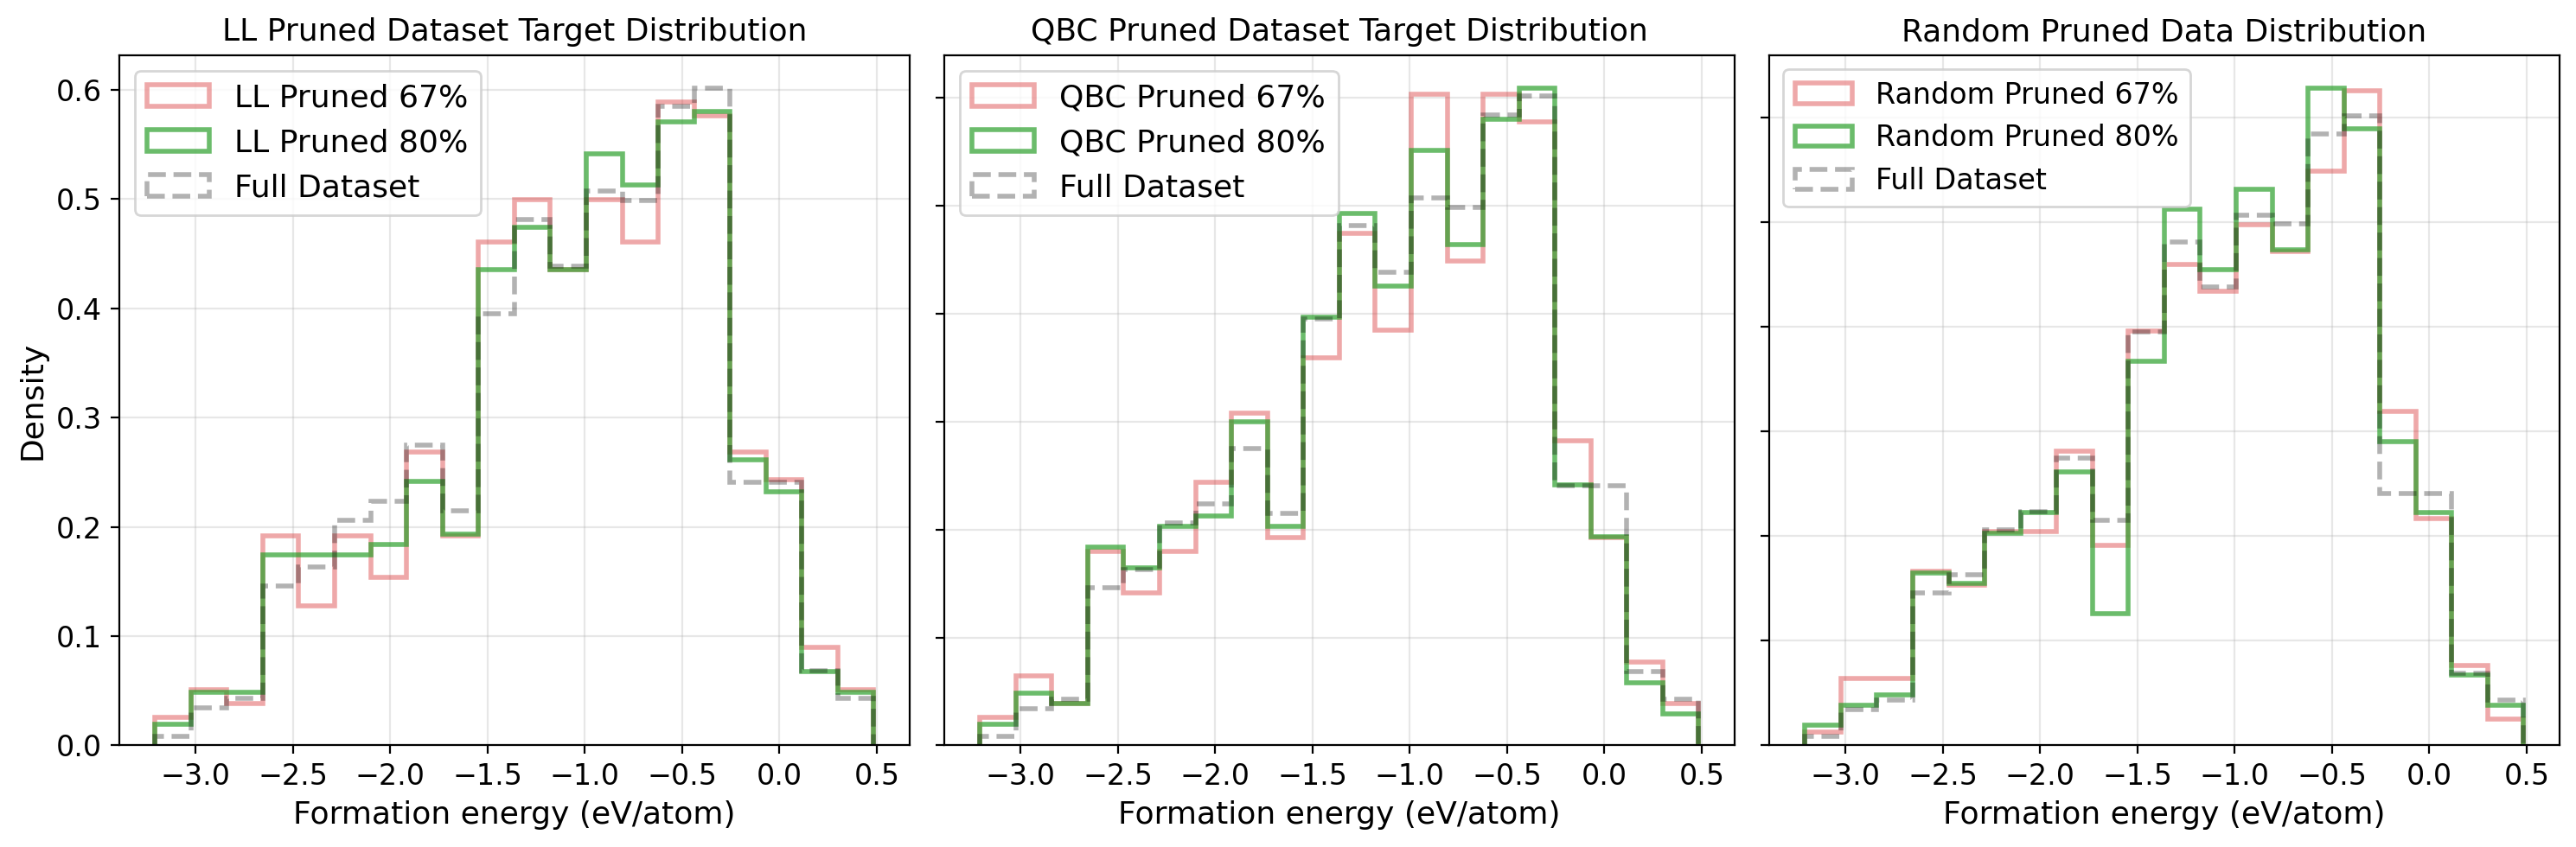

In [5]:
full_630_df = pd.read_pickle('data\subset\iter1_train\iter1_train.pkl')
full_630_dHf = full_630_df['dHf'].values

LL_pruned_1_prop = pd.read_csv(r'data\subset\pruning_expt_samples\pruned_datasets\LL_pruned_1\id_prop.csv', header=None, names=['file_name', 'dHf'])
LL_pruned_2_prop = pd.read_csv(r'data\subset\pruning_expt_samples\pruned_datasets\LL_pruned_2\id_prop.csv', header=None, names=['file_name', 'dHf'])
LL_pruned_3_prop = pd.read_csv('data\subset\pruning_expt_samples\pruned_datasets\LL_pruned_3\id_prop.csv', header=None, names=['file_name', 'dHf'])
LL_pruned_4_prop = pd.read_csv('data\subset\pruning_expt_samples\pruned_datasets\LL_pruned_4\id_prop.csv', header=None, names=['file_name', 'dHf'])
random_pruned_1_prop = pd.read_csv(r'data\subset\pruning_expt_samples\pruned_datasets\random_pruned_1\id_prop.csv', header=None, names=['file_name', 'dHf'])
random_pruned_2_prop = pd.read_csv(r'data\subset\pruning_expt_samples\pruned_datasets\random_pruned_2\id_prop.csv', header=None, names=['file_name', 'dHf'])
random_pruned_3_prop = pd.read_csv(r'data\subset\pruning_expt_samples\pruned_datasets\random_pruned_3\id_prop.csv', header=None, names=['file_name', 'dHf'])
random_pruned_4_prop = pd.read_csv(r'data\subset\pruning_expt_samples\pruned_datasets\random_pruned_4\id_prop.csv', header=None, names=['file_name', 'dHf'])
QBC_pruned_1_prop = pd.read_csv('data\subset\pruning_expt_samples\pruned_datasets\QBC\id_prop_1.csv', header=None, names=['file_name', 'dHf'])
QBC_pruned_2_prop = pd.read_csv('data\subset\pruning_expt_samples\pruned_datasets\QBC\id_prop_2.csv', header=None, names=['file_name', 'dHf'])
QBC_pruned_3_prop = pd.read_csv('data\subset\pruning_expt_samples\pruned_datasets\QBC\id_prop_3.csv', header=None, names=['file_name', 'dHf'])
QBC_pruned_4_prop = pd.read_csv('data\subset\pruning_expt_samples\pruned_datasets\QBC\id_prop_4.csv', header=None, names=['file_name', 'dHf'])

# Remove the last 70 entries from the 'dHf' column for each DataFrame
LL_pruned_1_prop_dHf = LL_pruned_1_prop['dHf'][:-70].values
LL_pruned_2_prop_dHf = LL_pruned_2_prop['dHf'][:-70].values
LL_pruned_3_prop_dHf = LL_pruned_3_prop['dHf'][:-70].values
LL_pruned_4_prop_dHf = LL_pruned_4_prop['dHf'][:-70].values
random_pruned_1_prop_dHf = random_pruned_1_prop['dHf'][:-70].values
random_pruned_2_prop_dHf = random_pruned_2_prop['dHf'][:-70].values
random_pruned_3_prop_dHf = random_pruned_3_prop['dHf'][:-70].values
random_pruned_4_prop_dHf = random_pruned_4_prop['dHf'][:-70].values
QBC_pruned_1_prop_dHf = QBC_pruned_1_prop['dHf'][:-70].values
QBC_pruned_2_prop_dHf = QBC_pruned_2_prop['dHf'][:-70].values
QBC_pruned_3_prop_dHf = QBC_pruned_3_prop['dHf'][:-70].values
QBC_pruned_4_prop_dHf = QBC_pruned_4_prop['dHf'][:-70].values

# Print lengths for each dataset
print(f"Full dataset length: {len(full_630_dHf)}")
print(f"LL pruned 1 length: {len(LL_pruned_1_prop_dHf)}")
print(f"LL pruned 2 length: {len(LL_pruned_2_prop_dHf)}")
print(f"LL pruned 3 length: {len(LL_pruned_3_prop_dHf)}")
print(f"LL pruned 4 length: {len(LL_pruned_4_prop_dHf)}")
print(f"Random pruned 1 length: {len(random_pruned_1_prop_dHf)}")
print(f"Random pruned 2 length: {len(random_pruned_2_prop_dHf)}")
print(f"Random pruned 3 length: {len(random_pruned_3_prop_dHf)}")
print(f"Random pruned 4 length: {len(random_pruned_4_prop_dHf)}")
print(f"QBC pruned 1 length: {len(QBC_pruned_1_prop_dHf)}")
print(f"QBC pruned 2 length: {len(QBC_pruned_2_prop_dHf)}")
print(f"QBC pruned 3 length: {len(QBC_pruned_3_prop_dHf)}")
print(f"QBC pruned 4 length: {len(QBC_pruned_4_prop_dHf)}")


# Create a single row with 3 plots for the pruned datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=200)
bins = 20
density = True

# Define a high contrast color scheme
high_contrast_colors = ['#1f77b4', '#d62728','#ff7f0e','#2ca02c',   'black']

# Compute histograms for LL pruned datasets
LL_pruned_1_hist, _ = np.histogram(LL_pruned_1_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)
LL_pruned_2_hist, _ = np.histogram(LL_pruned_2_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)
LL_pruned_3_hist, _ = np.histogram(LL_pruned_3_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)
LL_pruned_4_hist, _ = np.histogram(LL_pruned_4_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)

full_hist, _ = np.histogram(full_630_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)

# Plot density histograms for LL pruned datasets
axes[0].hist(LL_pruned_2_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density, histtype='step', linewidth=2, label='LL Pruned 67%', color=high_contrast_colors[1], alpha=0.4)
axes[0].hist(LL_pruned_4_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density, histtype='step', linewidth=2, label='LL Pruned 80%', color=high_contrast_colors[3], alpha=0.7)
axes[0].hist(full_630_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density, histtype='step', linestyle='--', linewidth=2, label='Full Dataset', color=high_contrast_colors[4], alpha=0.3)
axes[0].set_xlabel('Formation energy (eV/atom)', fontsize=13)
axes[0].set_ylabel('Density', fontsize=13)
axes[0].legend(fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].set_title('LL Pruned Dataset Target Distribution', fontsize=13)

# Compute histograms for QBC pruned datasets
QBC_pruned_1_hist, _ = np.histogram(QBC_pruned_1_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)
QBC_pruned_2_hist, _ = np.histogram(QBC_pruned_2_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)
QBC_pruned_3_hist, _ = np.histogram(QBC_pruned_3_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)
QBC_pruned_4_hist, _ = np.histogram(QBC_pruned_4_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)

# Plot density histograms for QBC pruned datasets
axes[1].hist(QBC_pruned_2_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density, histtype='step', linewidth=2, label='QBC Pruned 67%', color=high_contrast_colors[1], alpha=0.4)
axes[1].hist(QBC_pruned_4_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density, histtype='step', linewidth=2, label='QBC Pruned 80%', color=high_contrast_colors[3], alpha=0.7)
axes[1].hist(full_630_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density, histtype='step', linestyle='--', linewidth=2, label='Full Dataset', color=high_contrast_colors[4], alpha=0.3)
axes[1].set_xlabel('Formation energy (eV/atom)', fontsize=13)
axes[1].legend(fontsize=13)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='y', labelsize=12, labelleft=False)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].set_title('QBC Pruned Dataset Target Distribution', fontsize=13)

# Compute histograms for random pruned datasets
random_pruned_1_hist, _ = np.histogram(random_pruned_1_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)
random_pruned_2_hist, _ = np.histogram(random_pruned_2_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)
random_pruned_3_hist, _ = np.histogram(random_pruned_3_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)
random_pruned_4_hist, _ = np.histogram(random_pruned_4_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density)

# Plot density histograms for random pruned datasets
axes[2].hist(random_pruned_2_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density, histtype='step', linewidth=2, label='Random Pruned 67%', color=high_contrast_colors[1], alpha=0.4)
axes[2].hist(random_pruned_4_prop_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density, histtype='step', linewidth=2, label='Random Pruned 80%', color=high_contrast_colors[3], alpha=0.7)
axes[2].hist(full_630_dHf, bins=bins, range=(min(full_630_dHf), max(full_630_dHf)), density=density, histtype='step', linestyle='--', linewidth=2, label='Full Dataset', color=high_contrast_colors[4], alpha=0.3)
axes[2].set_xlabel('Formation energy (eV/atom)', fontsize=13)
axes[2].legend(fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='y', labelsize=12, labelleft=False)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].set_title('Random Pruned Data Distribution', fontsize=13)

plt.tight_layout()
plt.show()

### Comparative Distribution Visualization
Three-panel analysis comparing target distributions across pruning strategies:

- **Left Panel**: LL-pruned datasets vs full dataset
- **Center Panel**: QBC-pruned datasets vs full dataset  
- **Right Panel**: Random-pruned datasets vs full dataset


## 4. Model Loading and Evaluation Framework

### Comprehensive Model Collection
Loading and evaluating 37 trained ALIGNN models across different pruning configurations:

#### Model Organization
- **1 Full Dataset Model**: Baseline trained on all 630 samples
- **12 LL-Pruned Models**: 4 pruning levels × 3 random seeds
- **12 Random-Pruned Models**: 4 pruning levels × 3 random seeds  
- **12 QBC-Pruned Models**: 4 pruning levels × 3 random seeds

#### Evaluation Protocol
- **Consistent Architecture**: All models use identical ALIGNN configuration
- **Same Test Set**: 270 samples for fair comparison
- **Checkpoint Loading**: Models trained to 250 epochs for convergence

### Statistical Robustness Design
Multi-seed evaluation approach ensures reliable conclusions by accounting for training variability and providing error estimates for all performance metrics.


In [6]:
models = {}
models['model_full_630'] = r'models\Pruning_direct\trial1\checkpoint_250.pt'

model_paths = [r'models\Pruning_direct\LL_pruned_1_model\checkpoint_250.pt', 
               r'models\Pruning_direct\LL_pruned_2_model\checkpoint_250.pt',
               r'models\Pruning_direct\LL_pruned_3_model\checkpoint_250.pt',
               r'models\Pruning_direct\LL_pruned_4_model\checkpoint_250.pt',
               r'models\Pruning_direct\random_pruned_1_model\checkpoint_250.pt',
               r'models\Pruning_direct\random_pruned_2_model\checkpoint_250.pt',
               r'models\Pruning_direct\random_pruned_3_model\checkpoint_250.pt',
               r'models\Pruning_direct\random_pruned_4_model\checkpoint_250.pt',
               r'models\Pruning_direct\LL_pruned_1_model_2\checkpoint_250.pt', 
               r'models\Pruning_direct\LL_pruned_2_model_2\checkpoint_250.pt',
               r'models\Pruning_direct\LL_pruned_3_model_2\checkpoint_250.pt',
               r'models\Pruning_direct\LL_pruned_4_model_2\checkpoint_250.pt',
               r'models\Pruning_direct\random_pruned_1_model_2\checkpoint_250.pt',
               r'models\Pruning_direct\random_pruned_2_model_2\checkpoint_250.pt',
               r'models\Pruning_direct\random_pruned_3_model_2\checkpoint_250.pt',
               r'models\Pruning_direct\random_pruned_4_model_2\checkpoint_250.pt',
               r'models\Pruning_direct\LL_pruned_1_model_3\checkpoint_250.pt', 
               r'models\Pruning_direct\LL_pruned_2_model_3\checkpoint_250.pt',
               r'models\Pruning_direct\LL_pruned_3_model_3\checkpoint_250.pt',
               r'models\Pruning_direct\LL_pruned_4_model_3\checkpoint_250.pt',
               r'models\Pruning_direct\random_pruned_1_model_3\checkpoint_250.pt',
               r'models\Pruning_direct\random_pruned_2_model_3\checkpoint_250.pt',
               r'models\Pruning_direct\random_pruned_3_model_3\checkpoint_250.pt',
               r'models\Pruning_direct\random_pruned_4_model_3\checkpoint_250.pt',
               r'models\Pruning_direct\QBC_1_1_model\checkpoint_250.pt',
               r'models\Pruning_direct\QBC_1_2_model\checkpoint_250.pt',
               r'models\Pruning_direct\QBC_1_3_model\checkpoint_250.pt',
               r'models\Pruning_direct\QBC_2_1_model\checkpoint_250.pt',
               r'models\Pruning_direct\QBC_2_2_model\checkpoint_250.pt',
               r'models\Pruning_direct\QBC_2_3_model\checkpoint_250.pt',
               r'models\Pruning_direct\QBC_3_1_model\checkpoint_250.pt',
               r'models\Pruning_direct\QBC_3_2_model\checkpoint_250.pt',
               r'models\Pruning_direct\QBC_3_3_model\checkpoint_250.pt',
               r'models\Pruning_direct\QBC_4_1_model\checkpoint_250.pt',
               r'models\Pruning_direct\QBC_4_2_model\checkpoint_250.pt',
               r'models\Pruning_direct\QBC_4_3_model\checkpoint_250.pt']

for path in model_paths:
    model_name = path.split('\\')[-2]
    models[model_name] = path


## 5. Performance Analysis and Comparison

### Statistical Results Organization
Systematic organization of performance metrics by pruning strategy and dataset size:

#### Data Structure Design
- **Hierarchical Organization**: Results grouped by pruning method and sample count
- **Multi-Seed Aggregation**: Mean and standard deviation computation across random seeds
- **Comparative Framework**: Standardized metrics for direct strategy comparison
- **Error Quantification**: Statistical significance assessment through error bars

#### Performance Trends Analysis
- **Data Efficiency Curves**: Performance vs dataset size relationships
- **Method Comparison**: Direct comparison of LL vs QBC vs Random pruning
- **Statistical Significance**: Error bar analysis for meaningful differences
- **Baseline Comparison**: All methods compared against full dataset performance

This structured approach enables comprehensive analysis of pruning effectiveness across different data efficiency regimes.


In [7]:
for model_name, model_path in models.items():

    model_checkpoint = torch.load(model_path, map_location=torch.device(device), weights_only=False)
    model = ALIGNN()
    model.load_state_dict(model_checkpoint["model"])
    model.eval()

    model.to(device)
    model.eval()
    
    model_test_predictions = []
    original_test_targets = []
    for s in tqdm(test_data_loader):
        s0_device = s[0].to(device)
        s1_device = s[1].to(device)
        s2_device = s[2].to(device)
        original_test_targets.append(s2_device.detach().cpu().numpy()[0])
        y_pred = np.expand_dims(model([s0_device, s1_device]).detach().cpu().numpy(), axis=0)[0]
        model_test_predictions.append(y_pred)

    pred_col = f'pred_val_{model_name}'
    err_col = f'err_{model_name}'
    abs_err_col = f'abs_err_{model_name}'
    z_score_err_col = f'z_score_err_{model_name}'
    
    its_iter_1_data_df[pred_col] = np.array(model_test_predictions, dtype=float)
    its_iter_1_data_df[err_col] = (its_iter_1_data_df[target].astype(float) - its_iter_1_data_df[pred_col].astype(float))
    its_iter_1_data_df[abs_err_col] = np.abs(its_iter_1_data_df[target].astype(float) - its_iter_1_data_df[pred_col].astype(float))
    its_iter_1_data_df[z_score_err_col] = (its_iter_1_data_df[abs_err_col].astype(float) - np.mean(its_iter_1_data_df[abs_err_col].astype(float))) / np.std(its_iter_1_data_df[abs_err_col].astype(float))

100%|██████████| 270/270 [00:06<00:00, 43.03it/s]
C:\Users\EthanH24\AppData\Local\Temp\ipykernel_13580\961421910.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  its_iter_1_data_df[pred_col] = np.array(model_test_predictions, dtype=float)
C:\Users\EthanH24\AppData\Local\Temp\ipykernel_13580\961421910.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  its_iter_1_data_df[err_col] = (its_iter_1_data_df[target].astype(float) - its_iter_1_data_df[pred_col].astype(float))
C:\Users\EthanH24\AppData\Local\Tem

In [8]:
# Calculate MAE and MSE for each model
test_metrics = {}

for model_name in models.keys():
    abs_err_col = f'abs_err_{model_name}'
    err_col = f'err_{model_name}'
    
    if abs_err_col in its_iter_1_data_df.columns:
        # Test set metrics
        test_mae = np.mean(its_iter_1_data_df[abs_err_col].astype(float))
        test_mse = np.mean(its_iter_1_data_df[err_col].astype(float) ** 2)

        # Store in dictionaries
        test_metrics[model_name] = {'MAE': test_mae, 'MSE': test_mse}

In [9]:
# Define pruning levels and corresponding sample counts
pruning_levels = {
    'LL_pruned_1': 365,
    'LL_pruned_2': 424, 
    'LL_pruned_3': 501,
    'LL_pruned_4': 561,
    'random_pruned_1': 365,
    'random_pruned_2': 424,
    'random_pruned_3': 501,
    'random_pruned_4': 561,
    'model_full_630': 630,
    'QBC_1': 365,
    'QBC_2': 423,
    'QBC_3': 500,
    'QBC_4': 561,
}

# Model variations (different random seeds)
model_variations = ['_model', '_model_2', '_model_3']

# Organize data by pruning strategy and sample count
ll_pruned_results = {}
random_pruned_results = {}
QBC_pruned_results = {}
full_model_results = {}

QBC_variations = ['_1_model', '_2_model', '_3_model']

# Collect data for QBC pruned models
for i in range(1, 5):  
    base_name = f'QBC_{i}'
    sample_count = pruning_levels[base_name]
    
    mse_vals = []
    mae_vals = []
    
    for variation in QBC_variations:
        model_name = base_name + variation
        if model_name in test_metrics:
            mse_vals.append(test_metrics[model_name]['MSE'])
            mae_vals.append(test_metrics[model_name]['MAE'])
    
    if mse_vals:  # If we have data for this pruning level
        QBC_pruned_results[sample_count] = {
            'mse_mean': np.mean(mse_vals),
            'mse_std': np.std(mse_vals),
            'mae_mean': np.mean(mae_vals),
            'mae_std': np.std(mae_vals)
        }

In [ ]:
# Collect data for LL pruned models
for i in range(1, 5):  # LL_pruned_1 through LL_pruned_4
    base_name = f'LL_pruned_{i}'
    sample_count = pruning_levels[base_name]
    
    mse_vals = []
    mae_vals = []
    
    for variation in model_variations:
        model_name = base_name + variation
        if model_name in test_metrics:
            mse_vals.append(test_metrics[model_name]['MSE'])
            mae_vals.append(test_metrics[model_name]['MAE'])
    
    if mse_vals:  # If we have data for this pruning level
        ll_pruned_results[sample_count] = {
            'mse_mean': np.mean(mse_vals),
            'mse_std': np.std(mse_vals),
            'mae_mean': np.mean(mae_vals),
            'mae_std': np.std(mae_vals)
        }

# Collect data for random pruned models
for i in range(1, 5):  # random_pruned_1 through random_pruned_4
    base_name = f'random_pruned_{i}'
    sample_count = pruning_levels[base_name]
    
    mse_vals = []
    mae_vals = []
    
    for variation in model_variations:
        model_name = base_name + variation
        if model_name in test_metrics:
            mse_vals.append(test_metrics[model_name]['MSE'])
            mae_vals.append(test_metrics[model_name]['MAE'])
    
    if mse_vals:  # If we have data for this pruning level
        random_pruned_results[sample_count] = {
            'mse_mean': np.mean(mse_vals),
            'mse_std': np.std(mse_vals),
            'mae_mean': np.mean(mae_vals),
            'mae_std': np.std(mae_vals)
        }

# Collect data for full model
base_name = 'model_full_630'
sample_count = pruning_levels[base_name]

mse_vals = []
mae_vals = []

model_name = base_name 
if model_name in test_metrics:
    mse_vals.append(test_metrics[model_name]['MSE'])
    mae_vals.append(test_metrics[model_name]['MAE'])

if mse_vals:  # If we have data for the full model
    full_model_results[sample_count] = {
        'mse_mean': np.mean(mse_vals),
        'mse_std': np.std(mse_vals),
        'mae_mean': np.mean(mae_vals),
        'mae_std': np.std(mae_vals)
    }

### Performance Visualization and Trends
Comprehensive visualization of pruning strategy effectiveness:

#### Key Performance Questions
1. **Do intelligent pruning methods outperform random sampling?**
3. **How much performance is lost with aggressive pruning?**
4. **Which pruning method shows the most consistent performance?**

#### Statistical Interpretation
- **Overlapping Error Bars**: Indicate non-significant differences
- **Trend Analysis**: Performance scaling with dataset size


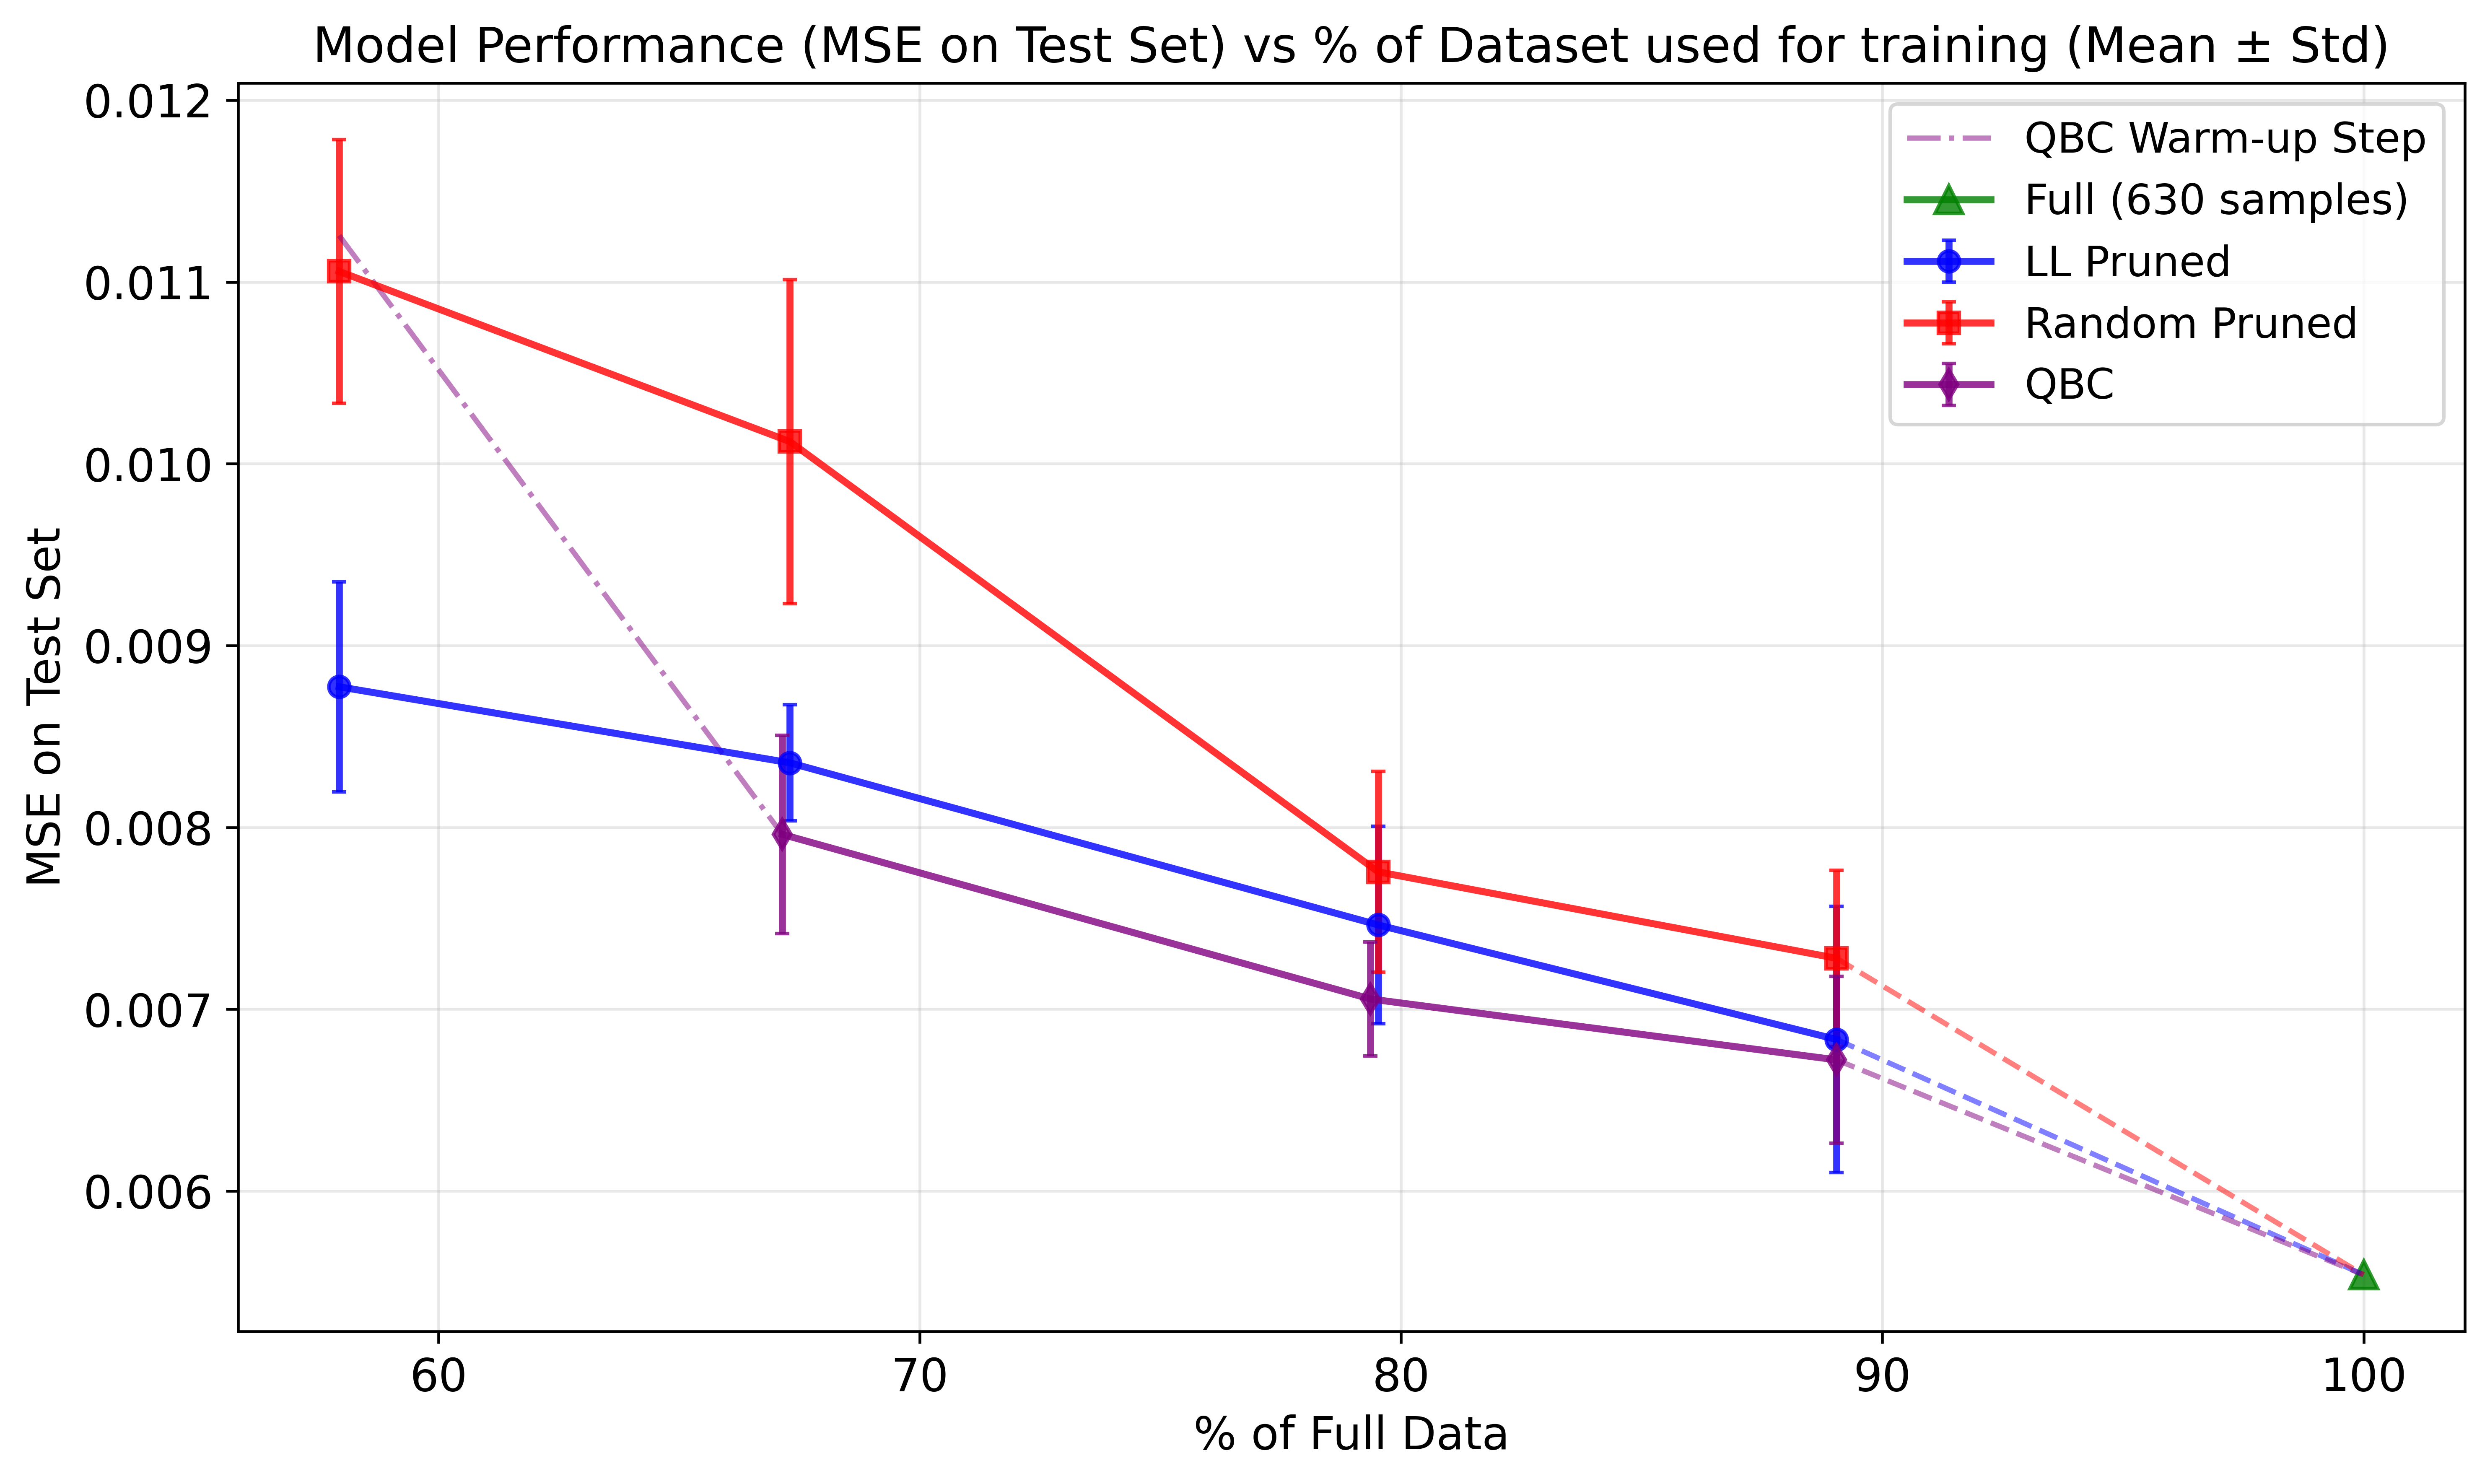

In [11]:

# Convert sample counts to percentages of full data (630)
full_data_size = 630

# Prepare data for plotting
ll_samples = sorted(ll_pruned_results.keys())
ll_percentages = [(s / full_data_size) * 100 for s in ll_samples]
ll_mse_means = [ll_pruned_results[s]['mse_mean'] for s in ll_samples]
ll_mse_stds = [ll_pruned_results[s]['mse_std'] for s in ll_samples]
ll_mae_means = [ll_pruned_results[s]['mae_mean'] for s in ll_samples]
ll_mae_stds = [ll_pruned_results[s]['mae_std'] for s in ll_samples]

random_samples = sorted(random_pruned_results.keys())
random_percentages = [(s / full_data_size) * 100 for s in random_samples]
random_mse_means = [random_pruned_results[s]['mse_mean'] for s in random_samples]
random_mse_stds = [random_pruned_results[s]['mse_std'] for s in random_samples]
random_mae_means = [random_pruned_results[s]['mae_mean'] for s in random_samples]
random_mae_stds = [random_pruned_results[s]['mae_std'] for s in random_samples]

full_samples = sorted(full_model_results.keys())
full_percentages = [(s / full_data_size) * 100 for s in full_samples]
full_mse_means = [full_model_results[s]['mse_mean'] for s in full_samples]
full_mse_stds = [full_model_results[s]['mse_std'] for s in full_samples]
full_mae_means = [full_model_results[s]['mae_mean'] for s in full_samples]
full_mae_stds = [full_model_results[s]['mae_std'] for s in full_samples]

QBC_samples = sorted(QBC_pruned_results.keys())
QBC_percentages = [(s / full_data_size) * 100 for s in QBC_samples]
QBC_mse_means = [QBC_pruned_results[s]['mse_mean'] for s in QBC_samples]
QBC_mse_stds = [QBC_pruned_results[s]['mse_std'] for s in QBC_samples]
QBC_mae_means = [QBC_pruned_results[s]['mae_mean'] for s in QBC_samples]
QBC_mae_stds = [QBC_pruned_results[s]['mae_std'] for s in QBC_samples]
# Plot MSE
plt.figure(figsize=(10, 6), dpi=600)

plt.errorbar(ll_percentages, ll_mse_means, yerr=ll_mse_stds, 
             label='LL Pruned', marker='o', capsize=2, capthick=1, linewidth=2, color='blue', alpha=0.8)
plt.errorbar(random_percentages, random_mse_means, yerr=random_mse_stds, 
             label='Random Pruned', marker='s', capsize=2, capthick=1, linewidth=2, color='red', alpha=0.8)
plt.errorbar(QBC_percentages[1:], QBC_mse_means[1:], yerr=QBC_mse_stds[1:], 
             label='QBC', marker='d', capsize=2, capthick=1, linewidth=2, color='purple', alpha=0.8)
plt.plot([QBC_percentages[0], QBC_percentages[1]], [QBC_mse_means[0], QBC_mse_means[1]], 
             '-.', color='purple', alpha=0.5, linewidth=1.5, label='QBC Warm-up Step')
plt.plot(full_percentages, full_mse_means, 
         label='Full (630 samples)', marker='^', linewidth=2, color='green', markersize=8, alpha=0.8)

# Add dashed lines connecting the last pruned point to the full model
if ll_percentages and full_percentages:
    plt.plot([ll_percentages[-1], full_percentages[0]], [ll_mse_means[-1], full_mse_means[0]], 
             '--', color='blue', alpha=0.5, linewidth=1.5)
if random_percentages and full_percentages:
    plt.plot([random_percentages[-1], full_percentages[0]], [random_mse_means[-1], full_mse_means[0]], 
             '--', color='red', alpha=0.5, linewidth=1.5)
if QBC_percentages and full_percentages:
    plt.plot([QBC_percentages[-1], full_percentages[0]], [QBC_mse_means[-1], full_mse_means[0]], 
             '--', color='purple', alpha=0.5, linewidth=1.5)

plt.xlabel('% of Full Data', fontsize=13)
plt.ylabel('MSE on Test Set', fontsize=13)
plt.title('Model Performance (MSE on Test Set) vs % of Dataset used for training (Mean ± Std)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, alpha=0.3)

# Set tick parameters
plt.tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()
plt.show()


### **Insight**

Both loss landscape and QBC pruning outperforms random sampling based off the prediction mean squared error on the ITS test set. The error bars between QBC and LL pruning overlap, indicating comparative performance.

## 6. Hessian Eigenvalue Analysis

### Loss Landscape Geometry Characterization

This analysis addresses the fundamental question: **Does intelligent pruning preserve better optimization landscape properties compared to random sampling?**


In [12]:
eigenvalue_files = [
    r"eigenvectors\iter_1_self_train_250_lowest_error\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_LL_pruned_1\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_LL_pruned_2\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_LL_pruned_3\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_LL_pruned_4\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_random_pruned_1\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_random_pruned_2\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_random_pruned_3\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_random_pruned_4\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_LL_pruned_1_model_2\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_LL_pruned_2_model_2\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_LL_pruned_3_model_2\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_LL_pruned_4_model_2\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_random_pruned_1_model_2\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_random_pruned_2_model_2\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_random_pruned_3_model_2\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_random_pruned_4_model_2\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_LL_pruned_1_model_3\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_LL_pruned_2_model_3\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_LL_pruned_3_model_3\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_LL_pruned_4_model_3\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_random_pruned_1_model_3\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_random_pruned_2_model_3\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_random_pruned_3_model_3\eigenvalues.txt",
    r"eigenvectors\iter_1_self_train_250_lowest_error_random_pruned_4_model_3\eigenvalues.txt",
]

In [13]:
max_eigenvals = {}
min_eigenvals = {}

for file_path in eigenvalue_files:
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
            
        # Extract model name from file path
        model_name = file_path.split('\\')[-2].replace('iter_1_self_train_250_lowest_error_', '')
        if model_name == 'iter_1_self_train_250_lowest_error':
            model_name = 'model_full_630'
        
        # Parse the eigenvalue information
        for line in lines:
            if line.startswith('Maximum eigenvalue:'):
                max_eigenval = float(line.split(':')[1].strip())
                max_eigenvals[model_name] = max_eigenval
            elif line.startswith('Minimum eigenvalue:'):
                min_eigenval = float(line.split(':')[1].strip())
                min_eigenvals[model_name] = min_eigenval
                
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")


model_variations = ['', '_model_2', '_model_3']

# Organize eigenvalue data by pruning strategy and sample count
ll_pruned_eigenvals = {}
random_pruned_eigenvals = {}
full_model_eigenvals = {}

# Collect eigenvalue data for LL pruned models
for i in range(1, 5):  # LL_pruned_1 through LL_pruned_4
    base_name = f'LL_pruned_{i}'
    sample_count = pruning_levels[base_name]
    
    max_eigenvals_list = []
    min_eigenvals_list = []
    
    for variation in model_variations:
        model_name = base_name + variation
        if model_name in max_eigenvals:
            max_eigenvals_list.append(max_eigenvals[model_name])
            min_eigenvals_list.append(min_eigenvals[model_name])
    
    if max_eigenvals_list:  # If we have data for this pruning level
        ll_pruned_eigenvals[sample_count] = {
            'max_eigenval_mean': np.mean(max_eigenvals_list),
            'max_eigenval_std': np.std(max_eigenvals_list),
            'min_eigenval_mean': np.mean(min_eigenvals_list),
            'min_eigenval_std': np.std(min_eigenvals_list)
        }

# Collect eigenvalue data for random pruned models
for i in range(1, 5):  # random_pruned_1 through random_pruned_4
    base_name = f'random_pruned_{i}'
    sample_count = pruning_levels[base_name]
    
    max_eigenvals_list = []
    min_eigenvals_list = []
    
    for variation in model_variations:
        model_name = base_name + variation
        if model_name in max_eigenvals:
            max_eigenvals_list.append(max_eigenvals[model_name])
            min_eigenvals_list.append(min_eigenvals[model_name])
    
    if max_eigenvals_list:  # If we have data for this pruning level
        random_pruned_eigenvals[sample_count] = {
            'max_eigenval_mean': np.mean(max_eigenvals_list),
            'max_eigenval_std': np.std(max_eigenvals_list),
            'min_eigenval_mean': np.mean(min_eigenvals_list),
            'min_eigenval_std': np.std(min_eigenvals_list)
        }

# Collect eigenvalue data for full model
base_name = 'model_full_630'
sample_count = pruning_levels[base_name]

max_eigenvals_list = []
min_eigenvals_list = []

model_name = base_name 
if model_name in max_eigenvals:
    max_eigenvals_list.append(max_eigenvals[model_name])
    min_eigenvals_list.append(min_eigenvals[model_name])

if max_eigenvals_list:  # If we have data for the full model
    full_model_eigenvals[sample_count] = {
        'max_eigenval_mean': np.mean(max_eigenvals_list),
        'max_eigenval_std': np.std(max_eigenvals_list),
        'min_eigenval_mean': np.mean(min_eigenvals_list),
        'min_eigenval_std': np.std(min_eigenvals_list)
    }



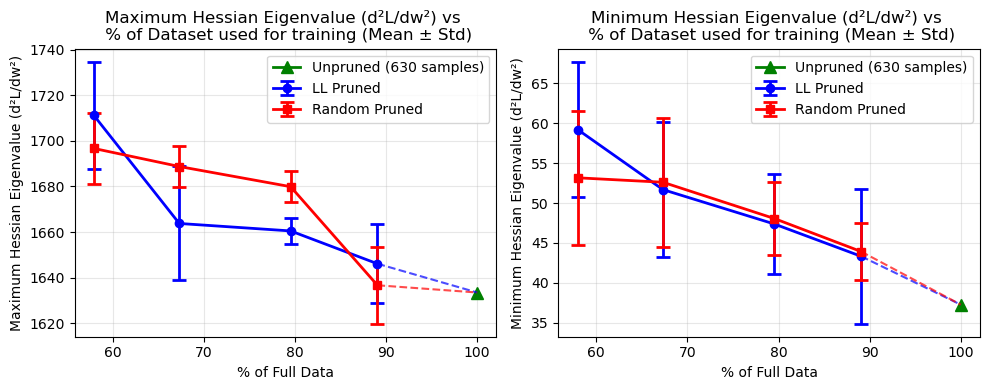

Eigenvalue Summary by Sample Count:

Sample Count: 365
------------------------------
LL Pruned    - Max Eigenval: 59.2103 ± 8.4757, Min Eigenval: 1711.1265 ± 23.5378
Random Pruned - Max Eigenval: 53.1621 ± 8.3838, Min Eigenval: 1696.6775 ± 15.7512

Sample Count: 423
------------------------------

Sample Count: 424
------------------------------
LL Pruned    - Max Eigenval: 51.6849 ± 8.4245, Min Eigenval: 1663.7819 ± 24.9958
Random Pruned - Max Eigenval: 52.6049 ± 8.0968, Min Eigenval: 1688.7593 ± 8.8823

Sample Count: 500
------------------------------

Sample Count: 501
------------------------------
LL Pruned    - Max Eigenval: 47.3779 ± 6.2693, Min Eigenval: 1660.5064 ± 5.7196
Random Pruned - Max Eigenval: 48.0645 ± 4.5359, Min Eigenval: 1679.9091 ± 6.6986

Sample Count: 561
------------------------------
LL Pruned    - Max Eigenval: 43.3364 ± 8.4374, Min Eigenval: 1646.1218 ± 17.4120
Random Pruned - Max Eigenval: 43.9312 ± 3.5751, Min Eigenval: 1636.6800 ± 16.8232

Sample Count: 

In [14]:
# Convert sample counts to percentages of full data (630)
full_data_size = 630

# Prepare eigenvalue data for plotting
ll_samples = sorted(ll_pruned_eigenvals.keys())
ll_percentages = [(s / full_data_size) * 100 for s in ll_samples]
ll_max_eigenval_means = [ll_pruned_eigenvals[s]['max_eigenval_mean'] for s in ll_samples]
ll_max_eigenval_stds = [ll_pruned_eigenvals[s]['max_eigenval_std'] for s in ll_samples]
ll_min_eigenval_means = [ll_pruned_eigenvals[s]['min_eigenval_mean'] for s in ll_samples]
ll_min_eigenval_stds = [ll_pruned_eigenvals[s]['min_eigenval_std'] for s in ll_samples]

random_samples = sorted(random_pruned_eigenvals.keys())
random_percentages = [(s / full_data_size) * 100 for s in random_samples]
random_max_eigenval_means = [random_pruned_eigenvals[s]['max_eigenval_mean'] for s in random_samples]
random_max_eigenval_stds = [random_pruned_eigenvals[s]['max_eigenval_std'] for s in random_samples]
random_min_eigenval_means = [random_pruned_eigenvals[s]['min_eigenval_mean'] for s in random_samples]
random_min_eigenval_stds = [random_pruned_eigenvals[s]['min_eigenval_std'] for s in random_samples]

full_samples = sorted(full_model_eigenvals.keys())
full_percentages = [(s / full_data_size) * 100 for s in full_samples]
full_max_eigenval_means = [full_model_eigenvals[s]['max_eigenval_mean'] for s in full_samples]
full_max_eigenval_stds = [full_model_eigenvals[s]['max_eigenval_std'] for s in full_samples]
full_min_eigenval_means = [full_model_eigenvals[s]['min_eigenval_mean'] for s in full_samples]
full_min_eigenval_stds = [full_model_eigenvals[s]['min_eigenval_std'] for s in full_samples]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot Minimum Eigenvalues with error bars
ax1.errorbar(ll_percentages, ll_min_eigenval_means, yerr=ll_min_eigenval_stds, 
             label='LL Pruned', marker='o', capsize=5, capthick=2, linewidth=2, color='blue')
ax1.errorbar(random_percentages, random_min_eigenval_means, yerr=random_min_eigenval_stds, 
             label='Random Pruned', marker='s', capsize=5, capthick=2, linewidth=2, color='red')
ax1.plot(full_percentages, full_min_eigenval_means, 
         label='Unpruned (630 samples)', marker='^', linewidth=2, color='green', markersize=8)

# Add dashed lines connecting the last pruned point to the full model
if ll_percentages and full_percentages:
    ax1.plot([ll_percentages[-1], full_percentages[0]], [ll_min_eigenval_means[-1], full_min_eigenval_means[0]], 
             '--', color='blue', alpha=0.7, linewidth=1.5)
if random_percentages and full_percentages:
    ax1.plot([random_percentages[-1], full_percentages[0]], [random_min_eigenval_means[-1], full_min_eigenval_means[0]], 
             '--', color='red', alpha=0.7, linewidth=1.5)

ax1.set_xlabel('% of Full Data')
ax1.set_ylabel('Maximum Hessian Eigenvalue (d²L/dw²)')
ax1.set_title('Maximum Hessian Eigenvalue (d²L/dw²) vs \n % of Dataset used for training (Mean ± Std)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Maximum Eigenvalues with error bars
ax2.errorbar(ll_percentages, ll_max_eigenval_means, yerr=ll_max_eigenval_stds, 
             label='LL Pruned', marker='o', capsize=5, capthick=2, linewidth=2, color='blue')
ax2.errorbar(random_percentages, random_max_eigenval_means, yerr=random_max_eigenval_stds, 
             label='Random Pruned', marker='s', capsize=5, capthick=2, linewidth=2, color='red')
ax2.plot(full_percentages, full_max_eigenval_means, 
         label='Unpruned (630 samples)', marker='^', linewidth=2, color='green', markersize=8)

# Add dashed lines connecting the last pruned point to the full model
if ll_percentages and full_percentages:
    ax2.plot([ll_percentages[-1], full_percentages[0]], [ll_max_eigenval_means[-1], full_max_eigenval_means[0]], 
             '--', color='blue', alpha=0.7, linewidth=1.5)
if random_percentages and full_percentages:
    ax2.plot([random_percentages[-1], full_percentages[0]], [random_max_eigenval_means[-1], full_max_eigenval_means[0]], 
             '--', color='red', alpha=0.7, linewidth=1.5)

ax2.set_xlabel('% of Full Data')
ax2.set_ylabel('Minimum Hessian Eigenvalue (d²L/dw²)')
ax2.set_title('Minimum Hessian Eigenvalue (d²L/dw²) vs \n % of Dataset used for training (Mean ± Std)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics grouped by sample count
print("Eigenvalue Summary by Sample Count:")
print("=" * 60)

all_sample_counts = sorted(set(pruning_levels.values()))
for sample_count in all_sample_counts:
    print(f"\nSample Count: {sample_count}")
    print("-" * 30)
    
    # LL Pruned results for this sample count
    if sample_count in ll_pruned_eigenvals:
        ll_data = ll_pruned_eigenvals[sample_count]
        print(f"LL Pruned    - Max Eigenval: {ll_data['max_eigenval_mean']:.4f} ± {ll_data['max_eigenval_std']:.4f}, Min Eigenval: {ll_data['min_eigenval_mean']:.4f} ± {ll_data['min_eigenval_std']:.4f}")
    
    # Random Pruned results for this sample count
    if sample_count in random_pruned_eigenvals:
        rand_data = random_pruned_eigenvals[sample_count]
        print(f"Random Pruned - Max Eigenval: {rand_data['max_eigenval_mean']:.4f} ± {rand_data['max_eigenval_std']:.4f}, Min Eigenval: {rand_data['min_eigenval_mean']:.4f} ± {rand_data['min_eigenval_std']:.4f}")
    
    # Full Model results for this sample count
    if sample_count in full_model_eigenvals:
        full_data = full_model_eigenvals[sample_count]
        print(f"Full Model   - Max Eigenval: {full_data['max_eigenval_mean']:.4f} ± {full_data['max_eigenval_std']:.4f}, Min Eigenval: {full_data['min_eigenval_mean']:.4f} ± {full_data['min_eigenval_std']:.4f}")
